In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

plt.rc('font', family='NanumBarunGothic') 
from collections import Counter

In [6]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/open/'

In [7]:
data_info_df = pd.read_csv(data_path + 'data_info.csv')
test_df = pd.read_csv(data_path + 'test.csv')
train_df = pd.read_csv(data_path + 'train.csv')

In [8]:
data_info_df

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [9]:
train_df

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


In [10]:
train_df.info()
# object 타입의 칼럼이 존재 -> 해당 부분 전처리 생각하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [11]:
# 결측치 확인
train_df.loc[train_df.isnull().any(axis = 1)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


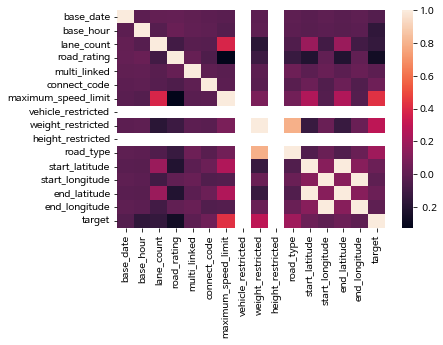

In [12]:
sns.heatmap(train_df.corr())

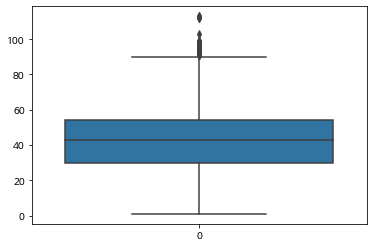

In [13]:
sns.boxplot(data=train_df['target'])
# 아웃라이어가 생각보다 많음

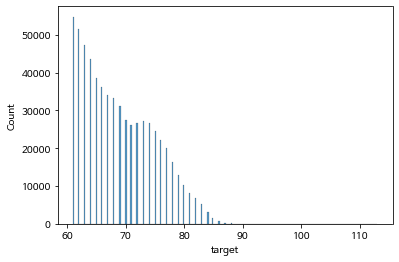

In [14]:
sns.histplot(data = train_df.loc[train_df.target > 60], x = 'target')

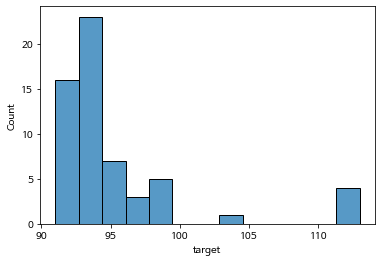

In [15]:
sns.histplot(data = train_df.loc[train_df.target > 90], x = 'target')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


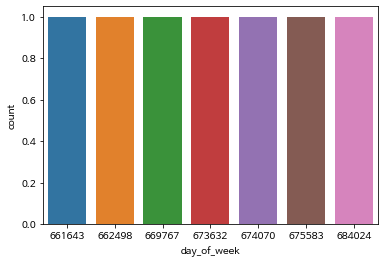

In [16]:
sns.countplot(train_df.day_of_week.value_counts())

In [17]:
day_of_week = ['월', '화', '수', '목', '금', '토', '일']

In [18]:
plt.rc('font', family='NanumBarunGothic') 

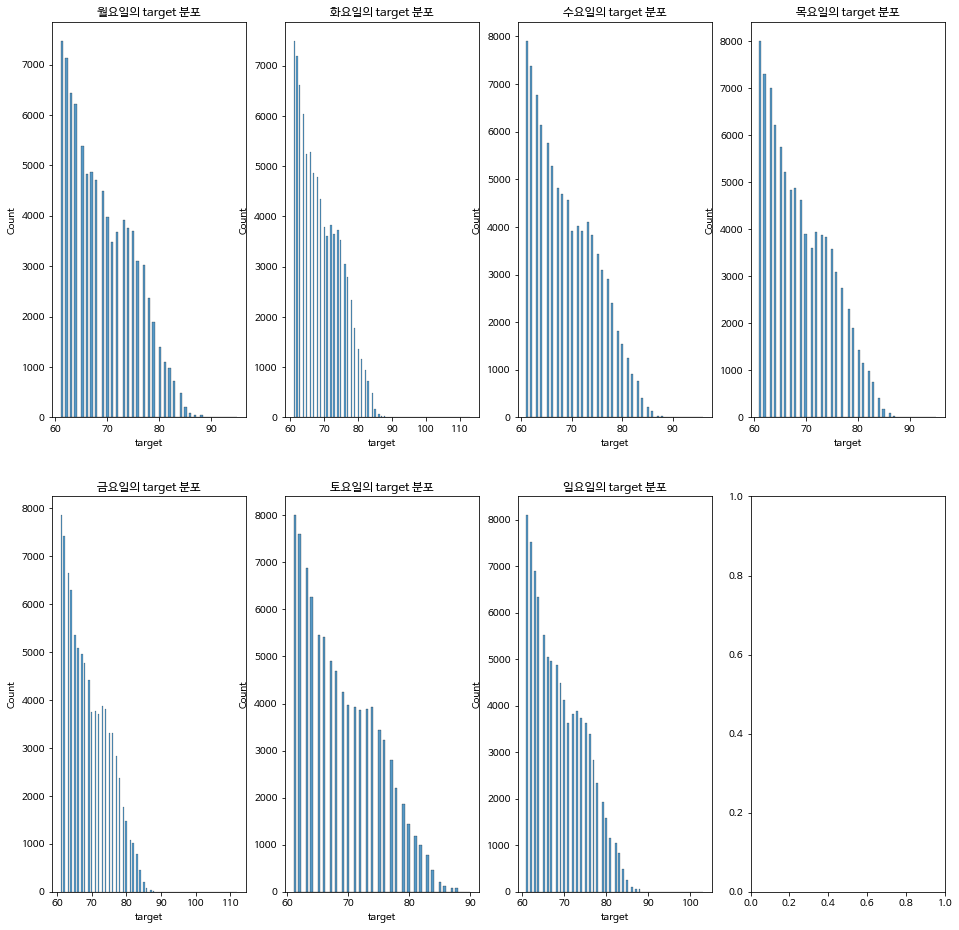

In [22]:
# 평균적으로 목요일이 가장 빠른 속도로 다님
f, ax = plt.subplots(2, 4, figsize=(16, 16))

for day in range(len(day_of_week)):
    sns.histplot(data = train_df.loc[(train_df.day_of_week==day_of_week[day])&(train_df.target>60)], x = 'target', ax=ax[day//4][day%4]);
    ax[day//4][day%4].set_title(f'{day_of_week[day]}요일의 target 분포');
f.show();

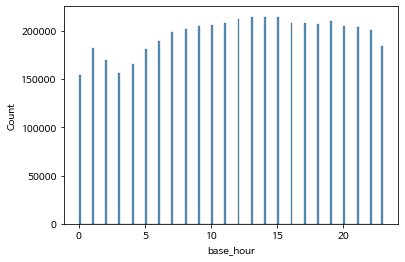

In [23]:
sns.histplot(train_df.base_hour)